#### Import Libraries

In [1]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

#### Setting the dataset path


In [2]:
#read DataSet
TrainImage="./Dataset/"

print(TrainImage)

./Dataset/


In [3]:
#to get all image names in train file
Pneumonaimages = os.listdir(TrainImage + "/PNEUMONIA")
Normalimages = os.listdir(TrainImage + "/NORMAL")
COVID19images = os.listdir(TrainImage + "/COVID19")

#### Explore the Data

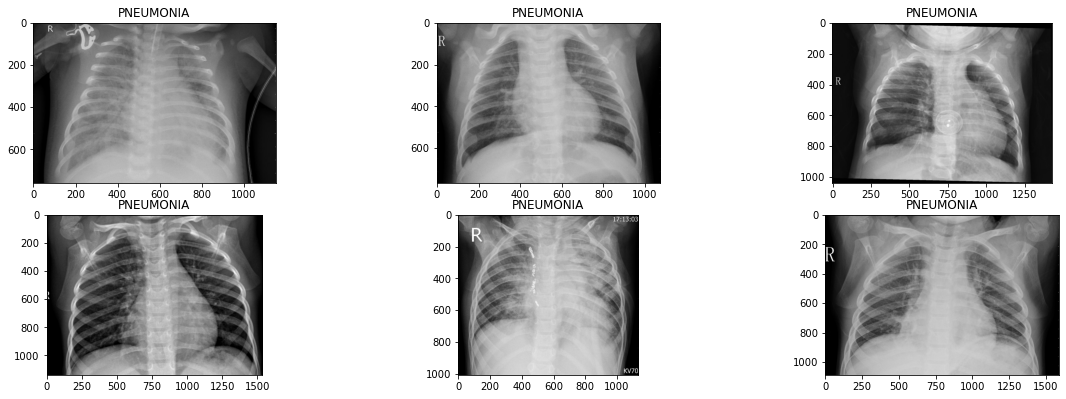

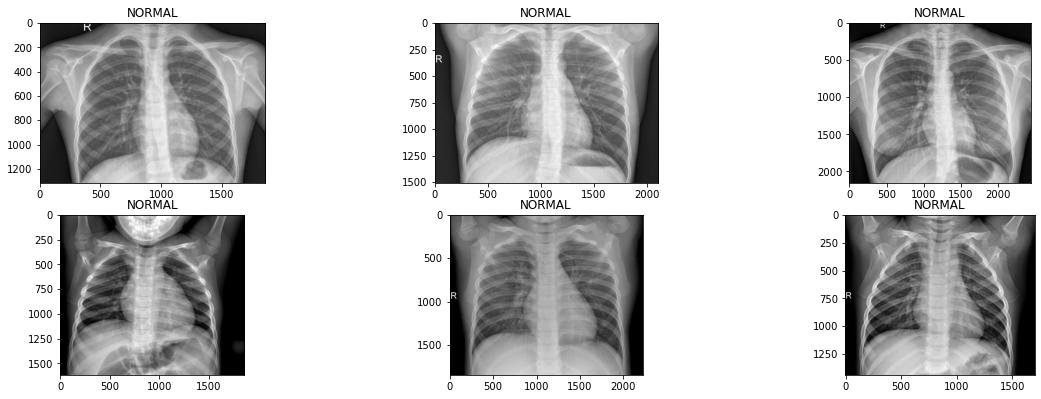

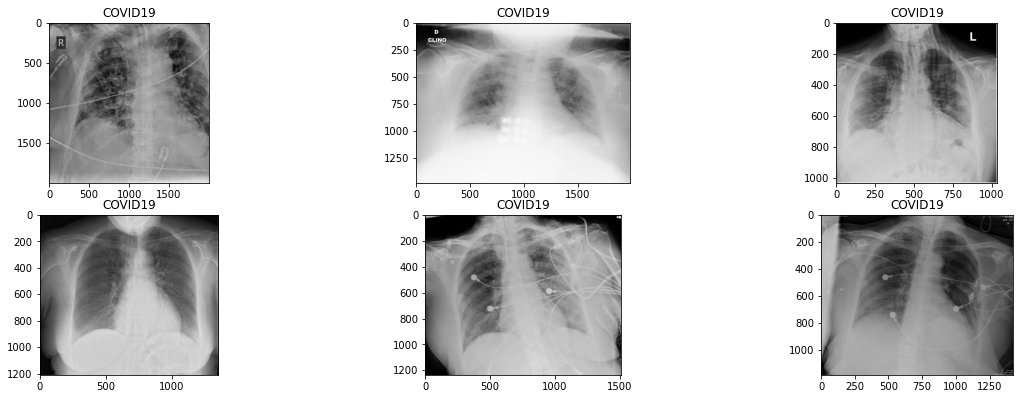

In [4]:
#plot to show the size of some image
#plot PNEUMONIA
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
    
plt.show()
#plot NORMAL
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")

plt.show()
#plot 
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")

#### ImageDataGenerator (DataAugmentation )

In [6]:
Labels={'COVID19':0,'NORMAL':1 ,'PNEUMONIA':2 }

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x
        
               
#Test        
print(getCode('COVID19'))
print(getLabel(1))

0
NORMAL


#### Load Data

In [8]:
#Reading image data
import glob as gb
import cv2  
sizeImage=300 # to resize the all image as same size

#to read all images from directory
def getData(Dir,sizeImage):
    X=[]
    y=[]
    for folder in  os.listdir(Dir) : #to get the file name 
        files = gb.glob(pathname= str( Dir  +"/" +folder+ '//*.jpg' )) # to get the images
        for file in files:
                picture=cv2.imread(file) #  or plt.imread(file)
                imageArray=cv2.resize(picture,(sizeImage,sizeImage))
                X.append(list(imageArray))
                y.append(getCode(folder))
    X=np.array(X)
    y=np.array(y)
    return X,y

In [9]:
#get train data
X_train, y_train = getData(TrainImage,sizeImage)


In [10]:
print("X_train Shape        ",X_train.shape)

X_train Shape         (6432, 300, 300, 3)


In [11]:
# #Convert y_train to categorical
y_train=to_categorical(y_train,3)
print("y_train ",y_train.shape)

y_train  (6432, 3)


In [12]:
train_datagen = ImageDataGenerator(
      samplewise_center=True,
      samplewise_std_normalization= True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest'
                                  )

#### Build Model

In [13]:
#load weight
Network_Weight="./DenseNet-BC-169-32-no-top.h5"
print(Network_Weight)

./DenseNet-BC-169-32-no-top.h5


In [14]:
from tensorflow.keras.applications.densenet import DenseNet169
pre_trained_model = DenseNet169(input_shape = (sizeImage, sizeImage, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(Network_Weight)
for layer in pre_trained_model.layers:
    layer.trainable = False  #to make the layers to Freeze Weights

In [15]:
from sklearn.metrics import roc_auc_score


In [16]:
from tensorflow.keras import Model


x = tf.keras.layers.Flatten()(pre_trained_model.output)

#Full Connected Layers
x = tf.keras.layers.Dense(512, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

x=tf.keras.layers.Dense(3 , activation='sigmoid')(x)   

model = Model( pre_trained_model.input, x) 

# print(model.summary())
model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
                                                                    

#### K-fold Cross Validation

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from sklearn.model_selection import KFold

# K-fold Cross Validation model evaluation
num_folds = 5
fold_no = 1
epochs = 20
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=None)

import numpy as np
from sklearn.model_selection import KFold

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

C:\Users\supriti.ghosh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
20/20 [==============================] - 540s 24s/step - loss: 3.9444 - accuracy: 0.5885 - auc: 0.6994
Epoch 2/20
20/20 [==============================] - 499s 25s/step - loss: 0.4544 - accuracy: 0.8345 - auc: 0.9292
Epoch 3/20
20/20 [==============================] - 562s 28s/step - loss: 0.2234 - accuracy: 0.8938 - auc: 0.9697
Epoch 4/20
20/20 [==============================] - 577s 29s/step - loss: 0.1645 - accuracy: 0.9187 - auc: 0.9815
Epoch 5/20
20/20 [==============================] - 535s 26s/step - loss: 0.1338 - accuracy: 0.9367 - auc: 0.9874
Epoch 6/20
20/20 [==============================] - 527s 26s/step - loss: 0.1292 - accuracy: 0.9407 - auc: 0.9869
Epoch 7/20
20/20 [==============================] - 478s 24s/step - loss: 0.1348 - accuracy: 0.9344 - auc: 0.9869
Epoch 8/20
20/20 [==============================] - 483s 24s/step - loss: 0.1127 - accuracy: 0.9426 - auc: 0.9904
Epoch 9/20
20/20 [==============================] - 479s 24s/step - loss: 0.1044 - accur

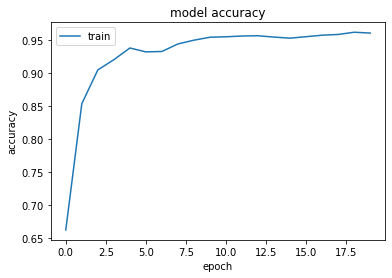

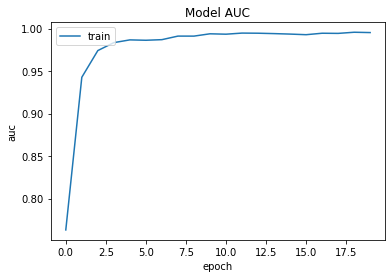

26/26 [==============================] - 129s 5s/step - loss: 0.0916 - accuracy: 0.9448 - auc: 0.9932
Score for fold 1: loss of 0.09156148135662079; accuracy of 94.48329210281372%; auc of 0.9932199716567993
Epoch 1/20
20/20 [==============================] - 702s 29s/step - loss: 0.0813 - accuracy: 0.9575 - auc: 0.9948
Epoch 2/20
20/20 [==============================] - 464s 23s/step - loss: 0.1136 - accuracy: 0.9403 - auc: 0.9904
Epoch 3/20
20/20 [==============================] - 462s 23s/step - loss: 0.1010 - accuracy: 0.9446 - auc: 0.9921
Epoch 4/20
20/20 [==============================] - 471s 23s/step - loss: 0.0926 - accuracy: 0.9507 - auc: 0.9933
Epoch 5/20
20/20 [==============================] - 459s 23s/step - loss: 0.0823 - accuracy: 0.9546 - auc: 0.9950
Epoch 6/20
20/20 [==============================] - 455s 23s/step - loss: 0.0847 - accuracy: 0.9566 - auc: 0.9939
Epoch 7/20
20/20 [==============================] - 454s 24s/step - loss: 0.0946 - accuracy: 0.9478 - auc: 0.

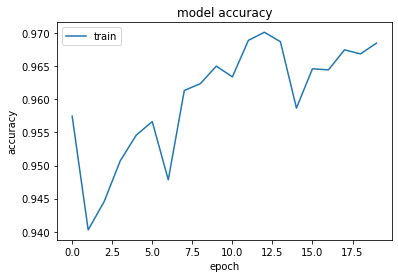

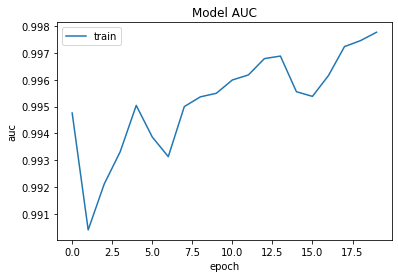

26/26 [==============================] - 122s 5s/step - loss: 0.0667 - accuracy: 0.9619 - auc: 0.9966
Score for fold 2: loss of 0.06670346111059189; accuracy of 96.19269371032715%; auc of 0.9966345429420471
Epoch 1/20
20/20 [==============================] - 760s 32s/step - loss: 0.0653 - accuracy: 0.9673 - auc: 0.9960
Epoch 2/20
20/20 [==============================] - 476s 23s/step - loss: 0.0593 - accuracy: 0.9664 - auc: 0.9974
Epoch 3/20
20/20 [==============================] - 453s 22s/step - loss: 0.0591 - accuracy: 0.9679 - auc: 0.9971
Epoch 4/20
20/20 [==============================] - 451s 22s/step - loss: 0.0608 - accuracy: 0.9699 - auc: 0.9964
Epoch 5/20
20/20 [==============================] - 453s 22s/step - loss: 0.0541 - accuracy: 0.9724 - auc: 0.9970
Epoch 6/20
20/20 [==============================] - 452s 22s/step - loss: 0.0550 - accuracy: 0.9746 - auc: 0.9972
Epoch 7/20
20/20 [==============================] - 452s 22s/step - loss: 0.0544 - accuracy: 0.9699 - auc: 0.

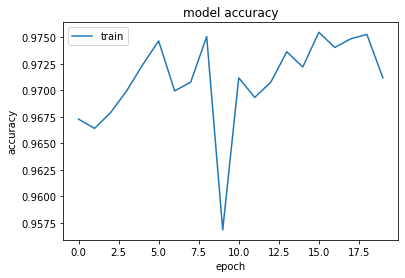

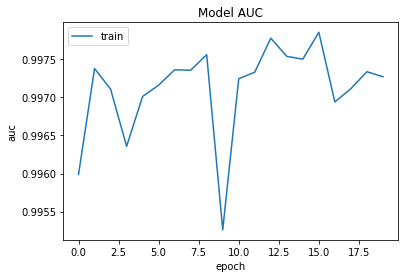

26/26 [==============================] - 120s 5s/step - loss: 0.0541 - accuracy: 0.9697 - auc: 0.9975
Score for fold 3: loss of 0.05407160893082619; accuracy of 96.96733951568604%; auc of 0.9974878430366516
Epoch 1/20
20/20 [==============================] - 622s 24s/step - loss: 0.0603 - accuracy: 0.9681 - auc: 0.9971
Epoch 2/20
20/20 [==============================] - 453s 22s/step - loss: 0.0535 - accuracy: 0.9710 - auc: 0.9974
Epoch 3/20
20/20 [==============================] - 451s 22s/step - loss: 0.0703 - accuracy: 0.9683 - auc: 0.9952
Epoch 4/20
20/20 [==============================] - 469s 23s/step - loss: 0.0563 - accuracy: 0.9682 - auc: 0.9971
Epoch 5/20
20/20 [==============================] - 450s 22s/step - loss: 0.0461 - accuracy: 0.9753 - auc: 0.9981
Epoch 6/20
20/20 [==============================] - 449s 23s/step - loss: 0.0467 - accuracy: 0.9757 - auc: 0.9976
Epoch 7/20
20/20 [==============================] - 453s 22s/step - loss: 0.0460 - accuracy: 0.9763 - auc: 0.

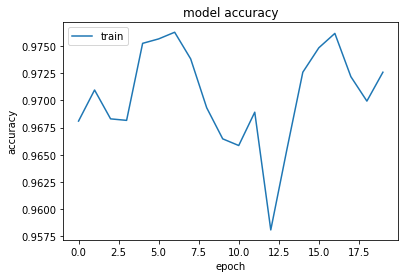

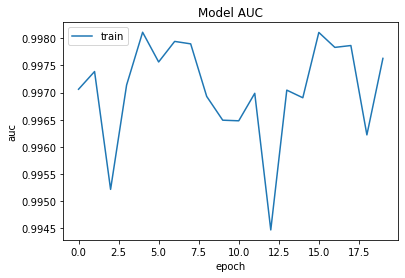

26/26 [==============================] - 121s 5s/step - loss: 0.0344 - accuracy: 0.9798 - auc: 0.9993
Score for fold 4: loss of 0.03437310457229614; accuracy of 97.97822833061218%; auc of 0.9992688894271851
Epoch 1/20
20/20 [==============================] - 519s 26s/step - loss: 0.0486 - accuracy: 0.9718 - auc: 0.9980
Epoch 2/20
20/20 [==============================] - 453s 22s/step - loss: 0.0540 - accuracy: 0.9699 - auc: 0.9976
Epoch 3/20
20/20 [==============================] - 449s 22s/step - loss: 0.0580 - accuracy: 0.9667 - auc: 0.9973
Epoch 4/20
20/20 [==============================] - 466s 23s/step - loss: 0.0591 - accuracy: 0.9691 - auc: 0.9963
Epoch 5/20
20/20 [==============================] - 450s 22s/step - loss: 0.0488 - accuracy: 0.9761 - auc: 0.9979
Epoch 6/20
20/20 [==============================] - 450s 22s/step - loss: 0.0487 - accuracy: 0.9722 - auc: 0.9983
Epoch 7/20
20/20 [==============================] - 453s 22s/step - loss: 0.0662 - accuracy: 0.9644 - auc: 0.

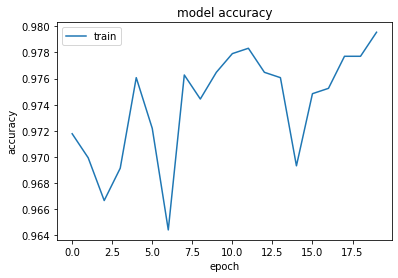

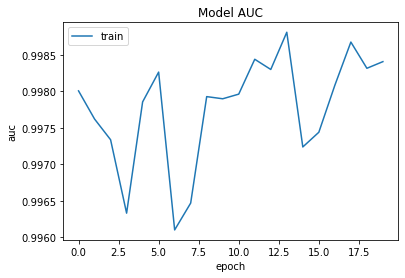

26/26 [==============================] - 122s 5s/step - loss: 0.0417 - accuracy: 0.9774 - auc: 0.9986
Score for fold 5: loss of 0.04171124845743179; accuracy of 97.74494767189026%; auc of 0.9986249804496765


In [20]:
score_list = []

for train, test in kfold.split(X_train, y_train):
    
    train_generator =train_datagen.flow(
         X_train[train], y_train[train],
         batch_size= 256
    )

    test_generator =train_datagen.flow(
         X_train[test], y_train[test],
         batch_size= 50
    )  
    
#     trainShape=train_generator.__getitem__(0)[0].shape
#     testShape=test_generator.__getitem__(0)[0].shape
#     print(trainShape)
#     print(testShape)

    history = model.fit_generator(train_generator,steps_per_epoch=20,callbacks=[lr_reduce,checkpoint] ,
             epochs=epochs)


    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['auc'])
    plt.title('Model AUC')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
  
    # Generate generalization metrics
    scores = model.evaluate(test_generator)
    score_list.append(scores)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1
 


In [21]:
for s in score_list:
    print(s[1]*100)

94.48329210281372
96.19269371032715
96.96733951568604
97.97822833061218
97.74494767189026
